<a href="https://colab.research.google.com/github/muh-zaid/ML-Finance-Course/blob/main/Interest_Rate_Prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

**Upload Data File**

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("DGS10.csv")

Saving DGS10.csv to DGS10.csv


**Data Pre-processing**

In [ ]:
# convert Data column into datetime format
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").reset_index(drop=True)

# coerce to numeric and remove missing values
df["IR"] = pd.to_numeric(df["IR"], errors="coerce")
df = df.dropna(subset=["IR"]).reset_index(drop=True)

df.head()

/tmp/ipython-input-296329316.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DATE"] = pd.to_datetime(df["DATE"])


,DATE,IR
0,2007-03-06,4.53
1,2007-03-07,4.50
2,2007-03-08,4.51
3,2007-03-09,4.59
4,2007-03-12,4.56


**Train Test Split**

In [ ]:
# split data on date pre and post 2021
split_date = pd.Timestamp("2021-01-01")

train_df = df[df["DATE"] < split_date].copy()
test_df = df[df["DATE"] >= split_date].copy()

print(f"Train rows are: {len(train_df)} and Test rows are: {len(test_df)}")

Train rows are: 3461 and Test rows are: 921


**Declaring Δt given business-day frequency**

In [ ]:
# DGS10 is business-day data (no weekends/holidays) so we approximate:
# Δt = 1/252 years (252 trading days per year)

dt = 1/252
print(f"Using constant dt = {dt}")

Using constant dt = 0.003968253968253968


**Vasicek calibration**

In [ ]:
def vasicek_calibrate(r, dt):
  # Discrete model:       r_t = r_{t-1} + a(b - r_{t-1})Δt + sigma * sqrt(Δt) * eps_t (where eps_t=Z and Δt is const equal 1/252 for bu)
  # Rearranged for OLS:   dr_t = r_t - r_{t-1} = (a*b*Δt) + (-a*Δt) * r_{t-1} + error_t

  # y i.e. dr in regression
  y = r[1:] - r[:-1]
  # x i.e. r_{t-1} in regression
  x = r[:-1]

  # OLS: dr = beta0 + beta1*x + resid
  X = np.column_stack([np.ones_like(x), x])
  beta0, beta1 = np.linalg.lstsq(X, y, rcond=None)[0]

  # Map betas to Vasicek params
  # beta0 = a*b*Δt, beta1 = -a*Δt
  a = -beta1 / dt
  b = beta0 / (-beta1) if beta1 != 0 else np.nan
  resid = y - (beta0 + beta1*x)

  # Var_resid = sigma^2 * Δt ==> sigma = sqrt(Var_resid/Δt)
  s2 = resid.var(ddof=2)
  sigma = np.sqrt(max(s2 / dt, 0.0))
  return a, b, sigma

**Vasicek forecast & volatility**

In [ ]:
def vasicek_forecast(r_prev, a, b, sigma, dt):
  # mean = r_{t-1} + a(b - r_{t-1})Δt
  # sd = sigma * sqrt(Δt)
  mean = r_prev + a * (b - r_prev) * dt
  sd = sigma * np.sqrt(dt)
  return mean, sd

**CIR calibration**

In [ ]:
def cir_calibrate(r, dt):
  EPS = np.finfo(float).eps
  # for missing values or values close to zero, fill with EPS value
  r = np.maximum(np.asarray(r, dtype=float), EPS)

  r0 = r[:-1]
  r1 = r[1:]
  y  = (r1 - r0) / np.sqrt(r0)

  # term with coefficient ab
  X1 = dt / np.sqrt(r0)
  # term with coefficient a
  X2 = -dt * np.sqrt(r0)
  # no intercept
  X  = np.column_stack([X1, X2])

  beta = np.linalg.lstsq(X, y, rcond=None)[0]
  ab_hat, a_hat = beta[0], beta[1]

  # find a and b
  a_hat = max(a_hat, EPS)
  b_hat = ab_hat / a_hat

  # residual and sigma
  resid = y - (ab_hat*X1 + a_hat*X2)
  s2 = resid.var(ddof=2)
  sigma_hat = np.sqrt(max(s2 / dt, 0.0))

  return a_hat, b_hat, sigma_hat

**CIR forecast & volatility**

In [ ]:
def cir_forecast(r_t, a, b, sigma, dt):
  EPS = np.finfo(float).eps

  r_t = max(float(r_t), EPS)
  m = np.exp(-a*dt)

  # calculate mean and standard dev of residual
  mean = r_t*m + b*(1-m)

  var = (r_t * (sigma**2)/a) * m*(1-m) + (b * (sigma**2)/(2*a)) * (1-m)**2
  sd  = np.sqrt(var)
  return mean, sd

**Main Code Block: Calls models for training/calibration**

In [ ]:
r_train = train_df["IR"].to_numpy()

# call training/calibration functions
a_v, b_v, s_v = vasicek_calibrate(r_train, dt)
a_c, b_c, s_c = cir_calibrate(r_train, dt)

print("Vasicek (a,b,sigma):", a_v, b_v, s_v)
print("CIR     (a,b,sigma):", a_c, b_c, s_c)

Vasicek (a,b,sigma): 0.5176272426453478 2.0750888593207213 0.9008782188135598
CIR     (a,b,sigma): 0.5356440094641893 2.0921265379893805 0.5889980353231039


**Call functions for Test data and forecast**

In [ ]:
rows = []
test_indices = test_df.index.to_numpy()

for idx in test_indices:
  if idx == 0:
    continue
  # previous IR for test_data
  r_prev = float(df.loc[idx-1, "IR"])
  # current Date for test_data
  date_t = df.loc[idx, "DATE"]
  # current IR for test_data
  actual = float(df.loc[idx, "IR"])

  # call forecast functions with test data
  v_mean, v_sd = vasicek_forecast(r_prev, a_v, b_v, s_v, dt)
  c_mean, c_sd = cir_forecast(r_prev, a_c, b_c, s_c, dt)

  rows.append({
      "DATE": date_t,
      "Actual": actual,
      "Vasicek_Forecast": v_mean,
      "Vasicek_SD": v_sd,
      "CIR_Forecast": c_mean,
      "CIR_SD": c_sd
  })

out = pd.DataFrame(rows)
out.head()

,DATE,Actual,Vasicek_Forecast,Vasicek_SD,CIR_Forecast,CIR_SD
0,2021-01-04,0.93,0.932352,0.05675,0.932468,0.035767
1,2021-01-05,0.96,0.932352,0.05675,0.932468,0.035767
2,2021-01-06,1.04,0.962290,0.05675,0.962404,0.036338
3,2021-01-07,1.08,1.042126,0.05675,1.042234,0.037818
4,2021-01-08,1.13,1.082044,0.05675,1.082149,0.038537


**Compute MSE and R² on the test period (2021+)**

In [ ]:
# calculate MSE and R^2 for Vasicek model
mse_v = mean_squared_error(out["Actual"], out["Vasicek_Forecast"])
r2_v  = r2_score(out["Actual"], out["Vasicek_Forecast"])

# calculate MSE and R^2 for CIR model
mse_c = mean_squared_error(out["Actual"], out["CIR_Forecast"])
r2_c  = r2_score(out["Actual"], out["CIR_Forecast"])

print("Vasicek: MSE =", mse_v, " R2 =", r2_v)
print("CIR:     MSE =", mse_c, " R2 =", r2_c)

Vasicek: MSE = 0.004326898319263701  R2 = 0.9968933843672861
CIR:     MSE = 0.004327016716088952  R2 = 0.9968932993610297


**Plot actual vs forecasts**

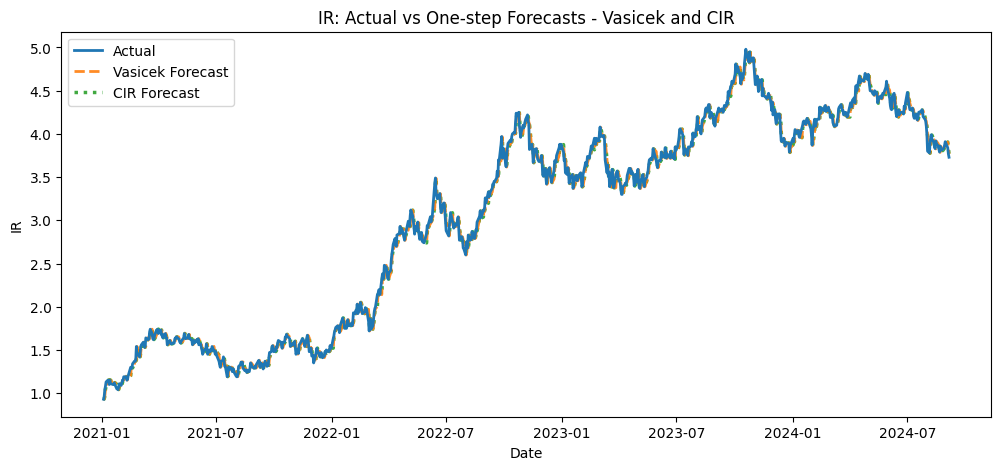

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(out["DATE"], out["Actual"], label="Actual", color="tab:blue", linewidth=2, zorder=3)
plt.plot(out["DATE"], out["Vasicek_Forecast"], label="Vasicek Forecast", color="tab:orange", linestyle="--", linewidth=2, alpha=0.9, zorder=2)
plt.plot(out["DATE"], out["CIR_Forecast"], label="CIR Forecast", color="tab:green", linestyle=":", linewidth=2.5, alpha=0.9, zorder=1)
plt.legend()
plt.xlabel("Date")
plt.ylabel("IR")
plt.title("IR: Actual vs One-step Forecasts - Vasicek and CIR")
plt.show()

**Plot forecast ± 1σ (volatility band) for better visibility**

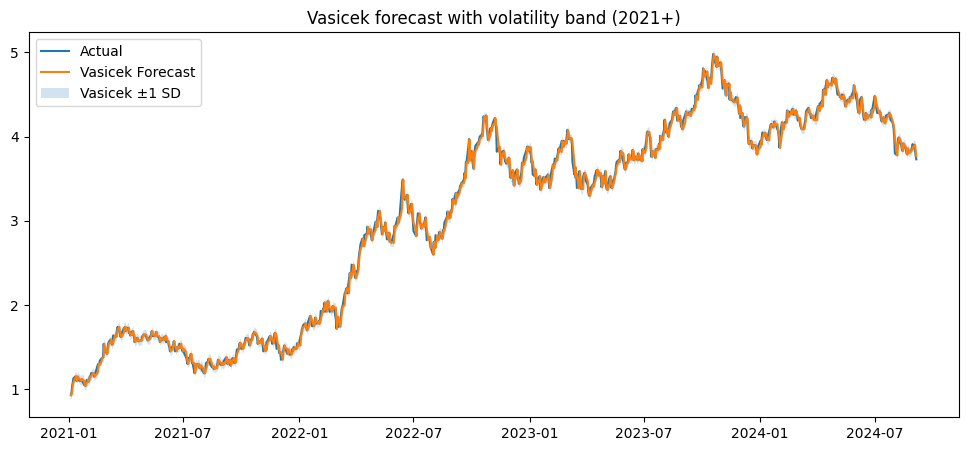

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(out["DATE"], out["Actual"], label="Actual")
plt.plot(out["DATE"], out["Vasicek_Forecast"], label="Vasicek Forecast")
plt.fill_between(out["DATE"], out["Vasicek_Forecast"] - out["Vasicek_SD"], out["Vasicek_Forecast"] + out["Vasicek_SD"], alpha=0.2, label="Vasicek ±1 SD")
plt.legend()
plt.title("Vasicek forecast with volatility band (2021+)")
plt.show()